In [50]:
import matplotlib.pyplot as plt
import re
from datetime import datetime

stat_dump_interval_s = 2

def plot_client_results(output_file, axs, xlim):
    # Define the file paths
    # input_file_path = 'agg_thread.txt'
    input_file_path = 'status_thread.txt'
    # input_file_path = 'status_thread2.txt'

    # Initialize a dictionary to hold the data
    client_data = {}

    # Compile the regular expressions for matching lines
    client_regex = re.compile(r'client(\d+) stats:')
    
    # data_regex = re.compile(r'.*(\d+) operations; \[(READ|UPDATE): Count=(\d+) Max=\d+\.\d+ Min=\d+\.\d+ Avg=(\d+\.\d+) 90=\d+\.\d+ 99=(\d+\.\d+) 99.9=(\d+\.\d+) 99.99=\d+\.\d+\]')
    data_regex = re.compile(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}).*operations; \[(READ|UPDATE|INSERT|INSERT_BATCH|SCAN): Count=(\d+) Max=\d+\.\d+ Min=\d+\.\d+ Avg=(\d+\.\d+) 90=\d+\.\d+ 99=(\d+\.\d+) 99.9=(\d+\.\d+) 99.99=\d+\.\d+\]')

    memtable_regex = re.compile(r'^memtables,([^,]+),(\d+),(\d+MB)$')

    def timestamp_to_seconds(timestamp_str):
        timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S')
        epoch = datetime(1970, 1, 1)
        return (timestamp - epoch).total_seconds()
    
    start_time = None

    client_prev_times = {}
    
    # Open and read the input file
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

        for i, line in enumerate(lines):
            client_match = client_regex.match(line)
            if not client_match:
                continue
            client_id = client_match.group(1)

            if i + 1 >= len(lines):
                continue

            data_match = data_regex.match(lines[i + 1])
            if data_match:
                # Extract the relevant data
                timestamp_str, op_name, count, avg, p99, p999 = data_match.group(1, 2, 3, 4, 5, 6)
                timestamp_s = timestamp_to_seconds(timestamp_str)
                if start_time is None:
                    start_time = timestamp_s

                if client_id in client_prev_times and timestamp_s < client_prev_times[client_id]:
                    client_id = str(int(client_id) + 2)
                client_prev_times[client_id] = timestamp_s

                # Check if the client ID already exists in the dictionary
                if client_id not in client_data:
                    client_data[client_id] = {'Tput': [], 'Avg': [], '99': [], '999': [], 'ts': []}

                # Append the data to the lists in the dictionary
                if op_name =='INSERT_BATCH':
                    multiplier = 100
                elif op_name == 'SCAN':
                    multiplier = 100
                else:
                    multiplier = 1
                client_data[client_id]['Tput'].append(multiplier*int(count)*16*1024/(1024*1024)/stat_dump_interval_s)
                # client_data[client_id]['Tput'].append(multiplier*int(count)*16*1024/(1024*1024)/stat_dump_interval_s)
                client_data[client_id]['Avg'].append(float(avg)/1000)
                client_data[client_id]['99'].append(float(p99)/1000)
                client_data[client_id]['999'].append(float(p999)/1000)
                client_data[client_id]['ts'].append(timestamp_s)

            j = i + 2
            while j < len(lines):
                memtable_match = memtable_regex.match(lines[j])
                if not memtable_match:
                    break
                j += 1
                
                cf_name, memtable_count, memtables_size = memtable_match.group(1,2,3)
                print(cf_name, memtable_count, memtables_size)
                
    def plot_metric(metric, title, ylabel, fig_loc):
        plt.figure(figsize=(8, 5))
        for client_id, stats in client_data.items():
            # time_points = [stat_dump_interval_s * i for i in range(len(stats[metric]))]
            # time_points = client_data[client_id]['ts']
            time_points = [ts - start_time for ts in client_data[client_id]['ts']]
            if metric == 'Count':
                data_points = [x for x in stats[metric]]
            else:
                data_points = [x for x in stats[metric]]
            axs[fig_loc[0]].plot(time_points, data_points, marker='o', label=f'Client {client_id}')
            with open(output_file, 'a') as outfile:
                outfile.write(f"client-{client_id}:metric-{metric}\n")
                outfile.write(f"time_points:{time_points}\n")
                outfile.write(f"data_points:{data_points}\n")
            
        
        if metric == 'Tput':

            # Get all the time points:
            all_time_points = [client_data[client_id]['ts'] for client_id in client_data]
            all_time_points = sorted(list(set([item for sublist in all_time_points for item in sublist])))

            # For each time point, sum the client throughputs.
            client_tput_sums = []
            for ts in all_time_points:
                cur_sum = 0
                for client_id in client_data:
                    if ts in client_data[client_id]['ts']:
                        idx = client_data[client_id]['ts'].index(ts)
                        cur_sum += client_data[client_id]['Tput'][idx]
                client_tput_sums.append(cur_sum)
            all_time_points = [ts - start_time for ts in all_time_points]
            axs[fig_loc[0]].plot(all_time_points, client_tput_sums, marker='o', label='Sum')

        axs[fig_loc[0]].set_title(title)
        axs[fig_loc[0]].set_xlabel('Time (s)')
        axs[fig_loc[0]].set_xlim(xlim)
        axs[fig_loc[0]].set_ylabel(ylabel)
        axs[fig_loc[0]].legend()
        axs[fig_loc[0]].grid(True)
        axs[fig_loc[0]].set_ylim(0, 100)
        # axs[fig_loc[0], fig_loc[1]].grid(True)

    # Plotting each metric
    plot_metric('Tput', 'Client Throughput', 'MB/s', (0, 0))
    plot_metric('Avg', 'Latency: Avg', '(ms)', (1, 0))
    plot_metric('99', 'Latency: 99p', '99th Percentile (ms)', (2, 0))

    return start_time


In [51]:
import matplotlib.pyplot as plt
import re
from datetime import datetime

stat_dump_interval_s = 2

def plot_memtable_stats(output_file, axs, start_time, xlim, fig_loc):
    # Define the file paths
    input_file_path = '/mnt/tgriggs-disk/ycsb-rocksdb-data/LOG'

    cf_data = {}

    # Compile the regular expressions for matching lines
    
    # memtable_regex = re.compile(r'^memtables,([^,]+),(\d+),(\d+)MB$')
    # memtable_regex = re.compile(r'^memtables,([^,]+),(\d+),(\d+)MB$')
    memtable_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}).\d{6} \d+ .*.cc:\d+\] mt,([^,]+),([^,]+).*')


    def timestamp_to_seconds(timestamp_str):
        timestamp_str = timestamp_str.strip()
        timestamp = datetime.strptime(timestamp_str, '%Y/%m/%d-%H:%M:%S')
        epoch = datetime(1970, 1, 1)
        return (timestamp - epoch).total_seconds()

    # Open and read the input file
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

        for i, line in enumerate(lines):
            memtable_match = memtable_pattern.match(line)
            if not memtable_match:
                continue
                
            ts, cf_name, operation = memtable_match.group(1, 2, 3)
            operation = operation.strip()
            if cf_name not in cf_data:
                # Assume 0 active memtables to start. Thus, this is basically tracking imm tables pending flush
                cf_data[cf_name] = {"counts" : [0], "ts" : [start_time]}
            cf_data[cf_name]["ts"].append(timestamp_to_seconds(ts))
            if operation == 'add':
                cf_data[cf_name]["counts"].append(cf_data[cf_name]["counts"][-1] + 1)
            elif operation == 'remove':
                cf_data[cf_name]["counts"].append(cf_data[cf_name]["counts"][-1] - 1)
            else:
                print('invalid memtable operation name')
                
                
    def plot_metric(metric, ax, colors):
        idx = 0
        for cf_name, stats in cf_data.items():
            data_points = [int(x) for x in stats[metric]]
            time_points = [ts - start_time for ts in stats["ts"]]

            # Ignore initial memtable init.
            ax.plot(time_points, data_points, marker='o', label=f'{cf_name}', color=colors[idx])
            with open(output_file, 'a') as outfile:
                outfile.write(f"cf-{cf_name}:metric-{metric}\n")
                outfile.write(f"time_points:{time_points}\n")
                outfile.write(f"data_points:{data_points}\n")


            idx += 1
        ax.set_xlabel('Time (s)')
            
    # Plotting each metric
    plot_metric('counts', axs[fig_loc[0]], ['blue', 'lightblue'])
    # plot_metric('counts', axs[fig_loc[0]], ['orange', '#ffd580'])
    axs[fig_loc[0]].set_xlim(xlim)
    axs[fig_loc[0]].set_title("Memtable Stats")
    axs[fig_loc[0]].legend(loc='upper left')
    axs[fig_loc[0]].grid(True)
    axs[fig_loc[0]].set_ylabel('Count')

    # size_ax = axs[fig_loc[0]].twinx()
    # plot_metric('table_sizes', size_ax, ['blue', 'lightblue'])
    # size_ax.legend(loc='upper right')
    # size_ax.set_ylabel('Memtables Size (MB)')
    # size_ax.set_ylim(0,128)
    # plt.subplots_adjust(right=0.85)

def plot_level_stats(output_file, axs, fig_loc):
    # Define the file paths
    input_file_path = '/mnt/tgriggs-disk/ycsb-rocksdb-data/LOG'

    level_data = {}
    level_hit_pattern = re.compile(r'rocksdb.l(0|1|2|3).hit COUNT : (\d+).*')

    hits = [None, None, None, None]
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

        for i, line in enumerate(lines):
            level_hit_match = level_hit_pattern.match(line)
            if not level_hit_match:
                continue
            level, new_hits = level_hit_match.group(1, 2)
            # Always overwrite.
            hits[int(level)] = int(new_hits)

    cumulative_hits = []
    cumulative_count = 0
    for hit in hits:
        cumulative_count += hit
        cumulative_hits.append(cumulative_count)
    cumulative_hits_prop = [x / cumulative_count * 100 for x in cumulative_hits]
    
    axs[fig_loc[0]].plot(["l0", "l1", "l2", "l3"], cumulative_hits_prop, marker='o')

    axs[fig_loc[0]].set_title("Level Hits CDF")
    axs[fig_loc[0]].grid(True)
    axs[fig_loc[0]].set_ylabel('Cumulative Hits (%)')

    with open(output_file, 'a') as outfile:
        outfile.write(f"metric-level_hits\n")
        outfile.write(f"data_points:{cumulative_hits_prop}\n")


In [56]:
import matplotlib.pyplot as plt
import re
import json
from datetime import datetime

def get_compaction_color(cf_name, level):
    # Red
    if cf_name == "default":
        if level == 1:
            return "#fc9598"
        elif level == 2:
            return "#ff696e"
        elif level == 3:
            return "#f02225"
        elif level == 4:
            return "#cf1d20"
        elif level == 5:
            return "#ab1619"
        elif level == 6:
            return "#851114"
        else:
        # elif level == 7:
            return "#610c0e"
    # Blue
    elif cf_name == "cf2":
        if level == 1:
            return "#95c2fc"
        elif level == 2:
            return "#699eff"
        elif level == 3:
            return "#225bf0"
        elif level == 4:
            return "#1d4bcf"
        elif level == 5:
            return "#1638ab"
        elif level == 6:
            return "#112985"
        else:
            # elif level == 7:
            return "#0c1d61"
    # Purple
    elif cf_name == "cf3":
        if level == 1:
            return "#c095fc"  # light purple
        elif level == 2:
            return "#a469ff"  # medium light purple
        elif level == 3:
            return "#8a22f0"  # medium purple
        elif level == 4:
            return "#741dcf"  # medium dark purple
        elif level == 5:
            return "#5b16ab"  # dark purple
        elif level == 6:
            return "#451185"  # darker purple
        else:
            # elif level == 7:
            return "#300c61"  # darkest purple
    elif cf_name == "cf4":
        if level == 1:
            return "#c9fcb2"  # light green
        elif level == 2:
            return "#9ff987"  # medium light green
        elif level == 3:
            return "#75f35d"  # medium green
        elif level == 4:
            return "#58d740"  # medium dark green
        elif level == 5:
            return "#46b334"  # dark green
        elif level == 6:
            return "#328028"  # darker green
        else:
            # elif level == 7:
            return "#21571d"  # darkest green


def plot_rocksdb_events(output_file, axs, experiment_start_time, xlim, fig_loc):
    # log_file_path = '/mnt/multi-cf2/ycsb-rocksdb-data-2/LOG'
    # log_file_path = '/mnt/multi-cf/ycsb-rocksdb-data/LOG'
    log_file_path = '/mnt/tgriggs-disk/ycsb-rocksdb-data/LOG'
    flush_regex = re.compile(
        r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}\.\d{6}) \d+ \[/flush_job\.cc:\d+\] \[(.*?)\] \[JOB \d+\] Flush: (\d+) microseconds, \d+ cpu microseconds, (\d+) bytes'
    )
    l0_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[default\] Stalling writes because we have \d+ level-0 files rate (\d+)')
    memtable_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[default\] Stalling writes because we have \d+ immutable memtables.*rate (\d+)')
    pending_compaction_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[default\] Stalling writes because of estimated pending compaction bytes \d+ rate (\d+)')
    memtable_stop_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[default\] Stopping writes because we have \d+ immutable memtables.*')

    compaction_regex = re.compile(r'.*EVENT_LOG_v1 (.*)$')
    def timestamp_to_seconds(timestamp_str):
        timestamp = datetime.strptime(timestamp_str, '%Y/%m/%d-%H:%M:%S.%f')
        epoch = datetime(1970, 1, 1)
        return (timestamp - epoch).total_seconds()

    def timestamp_to_micros(timestamp_str):
        timestamp_format = '%Y/%m/%d-%H:%M:%S.%f'
        dt = datetime.strptime(timestamp_str, timestamp_format)
        epoch = datetime(1970, 1, 1)
        micros_since_epoch = int((dt - epoch).total_seconds() * 1000000)
        return micros_since_epoch

    # Initialize lists for all events
    l0_stalls, memtable_stalls, pending_compaction_stalls, flush_data = [], [], [], []
    compaction_data = {}
    memtable_stops = []

    # Process the log file for stall, flush, and compaction events
    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            # L0 and Memtable Stalls
            l0_match = l0_stall_pattern.search(line)
            if l0_match:
                timestamp_str, rate = l0_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                l0_stalls.append((timestamp_micros, int(rate) / 1024 / 1024))

            memtable_match = memtable_stall_pattern.search(line)
            if memtable_match:
                timestamp_str, rate = memtable_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                memtable_stalls.append((timestamp_micros, int(rate) / 1024 / 1024))

            memtable_stop_match = memtable_stop_pattern.search(line)
            if memtable_stop_match:
                timestamp_str = memtable_stop_match.groups()[0]
                timestamp_micros = timestamp_to_micros(timestamp_str)
                memtable_stops.append(timestamp_micros)

            pending_compact_match = pending_compaction_stall_pattern.search(line)
            if pending_compact_match:
                timestamp_str, rate = pending_compact_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                pending_compaction_stalls.append((timestamp_micros, int(rate) / 1024 / 1024))

            # Flush Events
            flush_match = flush_regex.match(line)
            if flush_match:
                timestamp_str, cf_name, flush_microseconds, flush_bytes = flush_match.groups()
                start_time_seconds = timestamp_to_seconds(timestamp_str) - int(flush_microseconds) / 1e6
                rate_MB_s = (int(flush_bytes) / int(flush_microseconds)) * 1e6 / (1024**2)
                flush_data.append((start_time_seconds, rate_MB_s, int(flush_microseconds)/1e6, cf_name))
            
            # Compaction Events
            compaction_match = compaction_regex.match(line)
            if compaction_match:
                json_str = compaction_match.group(1)
                try:
                    event_data = json.loads(json_str)
                    if event_data['event'] != 'compaction_finished':
                        continue
                    end_time_seconds = event_data['time_micros'] / 1e6
                    start_time_seconds = end_time_seconds - event_data['compaction_time_micros'] / 1e6
                    # start_time_seconds = event_data['time_micros'] / 1e6
                    # end_time_seconds = start_time_seconds + event_data['compaction_time_micros'] / 1e6
                    read_rate = event_data['read_rate']
                    write_rate = event_data['write_rate']
                    output_level = event_data['output_level']
                    cf_name = event_data['cf_name']
                    if cf_name not in compaction_data:
                        compaction_data[cf_name] = []
                    compaction_data[cf_name].append((start_time_seconds, end_time_seconds, read_rate, write_rate, output_level))
                except:
                    print("Compaction json error")

    # Determine the overall start time
    all_start_times = [d[0] for d in flush_data + [compaction_data[cf_name][0] for cf_name in compaction_data] + l0_stalls + memtable_stalls]
    # experiment_start_time = min(all_start_times)
    # internal_start_time = min(all_start_times)
    # print(internal_start_time)
    print(experiment_start_time)

    # Convert L0 and Memtable timestamps to seconds since experiment start
    l0_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in l0_stalls]
    l0_rates = [int(rate) for _, rate in l0_stalls]

    memtable_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in memtable_stalls]
    memtable_rates = [int(rate) for _, rate in memtable_stalls]

    memtable_stop_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros in memtable_stops]

    pending_compaction_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in pending_compaction_stalls]
    pending_compaction_rates = [int(rate) for _, rate in pending_compaction_stalls]

    # Plotting
    # plt.figure(figsize=(8, 5))

    # Plot L0 and Memtable Stalls
    axs[fig_loc[0]].scatter(l0_timestamps, l0_rates, label='L0 Stalls', color='blue', s=10)
    axs[fig_loc[0]].scatter(memtable_timestamps, memtable_rates, label='Memtable Stalls', color='purple', s=10)
     # axs[fig_loc[0]].scatter(memtable_stop_timestamps, memtable_stops, label='Memtable Stops', color='brown', s=10)
    axs[fig_loc[0]].scatter(pending_compaction_timestamps, pending_compaction_rates, label='Pend Compact Stalls', color='orange', s=10)

    with open(output_file, 'a') as outfile:
        outfile.write(f"metric-L0_stalls\n")
        outfile.write(f"time_points:{l0_timestamps}\n")
        outfile.write(f"data_points:{l0_rates}\n")

        outfile.write(f"metric-memtable_stalls\n")
        outfile.write(f"time_points:{memtable_timestamps}\n")
        outfile.write(f"data_points:{memtable_rates}\n")

        outfile.write(f"metric-pending_compaction_stalls\n")
        outfile.write(f"time_points:{pending_compaction_timestamps}\n")
        outfile.write(f"data_points:{pending_compaction_rates}\n")
    
   
    # Plot Flush Events
    # TODO(tgriggs): Make this a dictionary keyed by column family 
    # for start_time, rate, duration, cf_name in flush_data:
    #     if cf_name == "default":
    #         color = 'red'
    #     elif cf_name == 'cf2':
    #         color = 'blue'
    #     elif cf_name == 'cf3':
    #         color = 'purple'
    #     elif cf_name == 'cf4':
    #         color = 'green'
    #     axs[fig_loc[0]].hlines(rate, start_time - experiment_start_time, (start_time + duration) - experiment_start_time, colors=color, linewidth=4, label='Flush' if flush_data.index((start_time, rate, duration, cf_name)) == 0 else "")

    for start_time, rate, duration, cf_name in flush_data:
        if cf_name == "default":
            color = 'red'
            label = 'CF1 Flush'
        elif cf_name == 'cf2':
            color = 'blue'
            label = 'CF2 Flush'
        elif cf_name == 'cf3':
            color = 'purple'
            label = 'CF3 Flush'
        elif cf_name == 'cf4':
            color = 'green'
            label = 'CF4 Flush'

        # Determine if this is the first occurrence of this cf_name for labeling
        is_first = flush_data.index((start_time, rate, duration, cf_name)) == 0
        # Plotting with custom dashed line pattern for stripes
        axs[fig_loc[0]].hlines(rate, start_time - experiment_start_time, 
                            (start_time + duration) - experiment_start_time, 
                            colors=color, linewidth=4, 
                            linestyles=(0, (5, 10)) if is_first else 'solid', 
                            label=label if is_first else "")

    # Plot Compaction Events
    for cf_name in compaction_data:
        for start_time, end_time, read_rate, write_rate, output_level in compaction_data[cf_name]:
            color = get_compaction_color(cf_name, output_level)
            if cf_name == 'default':
                label = 'CF1 Compaction'
            elif cf_name == 'cf2':
                label = 'CF2 Compaction'
            elif cf_name == 'cf3':
                label = 'CF3 Compaction'
            elif cf_name == 'cf4':
                label = 'CF4 Compaction'
            axs[fig_loc[0]].hlines(write_rate, start_time - experiment_start_time, end_time - experiment_start_time, colors=color, linewidth=2, label=label if compaction_data[cf_name].index((start_time, end_time, read_rate, write_rate, output_level)) == 0 else "")
            # axs[fig_loc[0]].hlines(read_rate, start_time - experiment_start_time, end_time - experiment_start_time, colors=color, linewidth=2, label=label if compaction_data[cf_name].index((start_time, end_time, read_rate, write_rate, output_level)) == 0 else "")
    
    for i in range(len(memtable_stop_timestamps)):
        memtable_stop_ts = memtable_stop_timestamps[i]
        if i == 0:
            axs[fig_loc[0]].axvline(x=memtable_stop_ts, color='brown', linestyle='--', linewidth=0.5, label = 'Memtable Stops', alpha=0.5)
        else:
            axs[fig_loc[0]].axvline(x=memtable_stop_ts, color='brown', linestyle='--', linewidth=0.5, alpha=0.5)

    with open(output_file, 'a') as outfile:
        outfile.write(f"metric-flush\n")
        outfile.write(f"rates:{[r for _,r,_,_ in flush_data]}\n")
        outfile.write(f"cf_names:{[cf for _,_,_,cf in flush_data]}\n")
        outfile.write(f"start_points:{[start_time - experiment_start_time for start_time,_,_,_ in flush_data]}\n")
        outfile.write(f"end_points:{[(start_time + duration) - experiment_start_time for start_time,_,duration,_ in flush_data]}\n")

        outfile.write(f"metric-compaction\n")
        all_cfs = []
        all_read_rates = []
        all_write_rates = []
        all_start_points = []
        all_end_points = []
        for cf in compaction_data:
            for start_time, end_time, read_rate, write_rate, _ in compaction_data[cf]:
                all_read_rates.append(read_rate)
                all_write_rates.append(write_rate)
                all_start_points.append(start_time)
                all_end_points.append(end_time)
                all_cfs.append(cf)
        outfile.write(f"cf_names:{all_cfs}\n")
        outfile.write(f"read_rates:{all_read_rates}\n")
        outfile.write(f"write_rates:{all_write_rates}\n")
        outfile.write(f"start_points:{[start_time - experiment_start_time for start_time in all_start_points]}\n")
        outfile.write(f"end_points:{[end_time - experiment_start_time for end_time in all_end_points]}\n")
        
        outfile.write(f"metric-memtable_stops\n")
        outfile.write(f"time_points:{memtable_stop_timestamps}\n")
        

    axs[fig_loc[0]].set_title('Database Operations Over Time')
    axs[fig_loc[0]].set_xlabel('Time (seconds since start of experiment)')
    axs[fig_loc[0]].set_ylabel('MB/s')
    axs[fig_loc[0]].set_xlim(xlim)
    axs[fig_loc[0]].set_ylim(0, 400)
    axs[fig_loc[0]].legend()
    axs[fig_loc[0]].grid(True)
    # plt.show()

In [57]:
# Overall throughputs (client + system)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import time

max_read_tput = 700
max_read_iops = 180000
max_write_tput = 400
max_write_iops = 100000

def timestamp_to_seconds(timestamp_str):
  timestamp = datetime.strptime(timestamp_str.rstrip(), '%Y-%m-%d %H:%M:%S.%f')
  epoch = datetime(1970, 1, 1)
  return (timestamp - epoch).total_seconds()

def plot_overall_tputs(output_file, axs, start_time_shift, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")

  # print(f"Timestamp: {timestamp_to_seconds(df_from_csv['Timestamp'][0])}")

  time_seconds = np.arange(len(df_from_csv))
  time_seconds = [x + start_time_shift for x in time_seconds]

  # Plotting
  # axs[fig_loc[0]].figure(figsize=(10, 6))
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["rMB/s"], label='Read MB/s', marker='o', color='tab:green')
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["wMB/s"], label='Write MB/s', marker='o', color='tab:red')

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-rMB_rate\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["rMB/s"].tolist()}\n")

    outfile.write(f"metric-wMB_rate\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["wMB/s"].tolist()}\n")

  axs[fig_loc[0]].set_title('SSD Throughput Over Time')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('MB/s')
  axs[fig_loc[0]].set_xlim(xlim)
  axs[fig_loc[0]].legend(loc='upper left')
  axs[fig_loc[0]].grid(True)

  # # Creating a second y-axis
  # ax2 = axs[fig_loc[0]].twinx()
  # # Plotting on the secondary y-axis
  # ax2.plot(time_seconds, df_from_csv["rMB/s"]/max_read_tput, label='Read Util', marker='x', linestyle='--', color='tab:green')
  # ax2.plot(time_seconds, df_from_csv["wMB/s"]/max_write_tput, label='Write Util', marker='+', linestyle='--', color='tab:red')
  # ax2.set_ylabel('Utilization (based on tput)')
  # ax2.legend(loc='upper right')
  # ax2.set_ylim(0,1)

  # Adjust the right margin to accommodate the second y-axis legend
  plt.subplots_adjust(right=0.85)

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-rMB_util\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{(df_from_csv["rMB/s"]/max_read_tput).tolist()}\n")

    outfile.write(f"metric-wMB_util\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{(df_from_csv["wMB/s"]/max_write_tput).tolist()}\n")

def plot_overall_iops(output_file, axs, start_time_shift, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")
  time_seconds = np.arange(len(df_from_csv))
  time_seconds = [x + start_time_shift for x in time_seconds]

  axs[fig_loc[0]].plot(time_seconds, df_from_csv["r/s"], label='Read IOPS', marker='o', color='tab:green')
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["w/s"], label='Write IOPS ', marker='o', color='tab:red')

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-rIOP_rate\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["r/s"].tolist()}\n")

    outfile.write(f"metric-wIOP_rate\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["w/s"].tolist()}\n")

  axs[fig_loc[0]].set_title('SSD IOPS Over Time')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('IOPS')
  axs[fig_loc[0]].set_xlim(xlim)
  # axs[fig_loc[0]].set_ylim(0,16)
  axs[fig_loc[0]].legend(loc='upper right')
  axs[fig_loc[0]].grid(True)

  # Creating a second y-axis
  ax2 = axs[fig_loc[0]].twinx()
  # Plotting on the secondary y-axis
  ax2.plot(time_seconds, df_from_csv["r/s"]/max_read_iops, label='Read IOPS Util', marker='x', linestyle='--', color='tab:green')
  ax2.plot(time_seconds, df_from_csv["w/s"]/max_write_iops, label='Write IOPS Util', marker='+', linestyle='--', color='tab:red')
  ax2.set_ylabel('Utilization (based on iops)')
  ax2.legend(loc='upper right')
  ax2.set_ylim(0,1)

  # Adjust the right margin to accommodate the second y-axis legend
  plt.subplots_adjust(right=0.85)

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-rIOP_util\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{(df_from_csv["r/s"]/max_read_iops).tolist()}\n")

    outfile.write(f"metric-wIOP_util\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{(df_from_csv["w/s"]/max_write_iops).tolist()}\n")

def plot_io_waittimes(output_file, axs, start_time_shift, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")
  time_seconds = np.arange(len(df_from_csv))
  time_seconds = [x + start_time_shift for x in time_seconds]

  axs[fig_loc[0]].plot(time_seconds, df_from_csv["r_await"], label='Read Await (per req)', marker='o', color='tab:green')
  # axs[fig_loc[0]].plot(time_seconds, df_from_csv["w_await"], label='Write Await (per req)', marker='o', color='tab:red')

  axs[fig_loc[0]].set_title('IO Wait Times (queueing + servicing)')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('Wait Time (ms)')
  axs[fig_loc[0]].set_xlim(xlim)
  # axs[fig_loc[0]].set_ylim(0,1)
  axs[fig_loc[0]].legend(loc='upper left')
  axs[fig_loc[0]].grid(True)

  ax2 = axs[fig_loc[0]].twinx()
  ax2.plot(time_seconds, [df_from_csv["r_await"][i] / df_from_csv["rareq-sz"][i] if df_from_csv["rareq-sz"][i] > 0 else df_from_csv["r_await"][i] for i in range(len(df_from_csv["r_await"]))], label='Read Await (per KB)', marker='x', color='tab:green')
  # ax2.plot(time_seconds, [df_from_csv["w_await"][i] / df_from_csv["wareq-sz"][i] if df_from_csv["wareq-sz"][i] > 0 else df_from_csv["w_await"][i]   for i in range(len(df_from_csv["w_await"]))], label='Write Await (per KB)', marker='x', color='tab:red')

  ax2.set_ylabel('IO Wait Times per KB')
  ax2.legend(loc='upper right')
  plt.subplots_adjust(right=0.85)

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-r_await\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["r_await"].tolist()}\n")

    outfile.write(f"metric-r_await_per_kb\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{[df_from_csv["r_await"][i] / df_from_csv["rareq-sz"][i] if df_from_csv["rareq-sz"][i] > 0 else df_from_csv["r_await"][i] for i in range(len(df_from_csv["r_await"]))]}\n")

def plot_io_reqsize(output_file, axs, start_time_shift, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")
  time_seconds = np.arange(len(df_from_csv))
  time_seconds = [x + start_time_shift for x in time_seconds]

  axs[fig_loc[0]].plot(time_seconds, df_from_csv["rareq-sz"], label='Avg Read Size', marker='o', color='tab:green')
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["wareq-sz"], label='Avg Write Size', marker='o', color='tab:red')

  axs[fig_loc[0]].set_title('Avg IO Sizes')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('Size (KB)')
  axs[fig_loc[0]].set_xlim(xlim)
  # axs[fig_loc[0]].set_ylim(0,1)
  axs[fig_loc[0]].legend(loc='upper right')
  axs[fig_loc[0]].grid(True)

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-r_size\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["rareq-sz"].tolist()}\n")

    outfile.write(f"metric-w_size\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["wareq-sz"].tolist()}\n")

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def plot_cpu_util(output_file, axs, start_time_shift, xlim, fig_loc):
    df = pd.read_csv("mpstat_results.csv")
    
    # Assuming core values are strings and stripping any potential whitespace
    df['core'] = df['core'].map(lambda x: x.strip())
    df_filtered = df[df['core'].isin(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'])].copy()

    # Convert metrics to float
    df_filtered['usr'] = df_filtered['usr'].map(lambda x: float(x))
    df_filtered['sys'] = df_filtered['sys'].map(lambda x: float(x))
    df_filtered['iowait'] = df_filtered['iowait'].map(lambda x: float(x))
    df_filtered['soft'] = df_filtered['soft'].map(lambda x: float(x))
    df_filtered['idle'] = df_filtered['idle'].map(lambda x: float(x))

    # Calculate the sum of iowait and idle for each row
    df_filtered['sum_iowait_idle'] = df_filtered['iowait'] + df_filtered['idle']
    
    # For plotting purposes, assuming each row represents a sequential time unit
    time_seconds = np.arange(len(df_filtered))
    time_seconds = [x + start_time_shift for x in time_seconds]

    # Group by core and plot each group
    for core, group in df_filtered.groupby('core'):
        # Calculate the index for each group based on its length
        group_index = list(np.arange(len(group)))
        axs[fig_loc[0]].plot(group_index, [100 - x for x in group['sum_iowait_idle']], label=f'Core {core} idle+iowait')
        with open(output_file, 'a') as outfile:
            outfile.write(f"metric-cpu_util:core-{core}\n")
            outfile.write(f"time_points:{group_index}\n")
            outfile.write(f"data_points:{[100 - x for x in group['sum_iowait_idle']]}\n")

    axs[fig_loc[0]].set_title('CPU Utilization (all but iowait and idle)')
    axs[fig_loc[0]].set_xlabel('Time (seconds)')
    axs[fig_loc[0]].legend(loc='upper right')
    axs[fig_loc[0]].grid(True)
    axs[fig_loc[0]].set_xlim(xlim)
    axs[fig_loc[0]].set_ylim(-2, 102)


1720236733.0


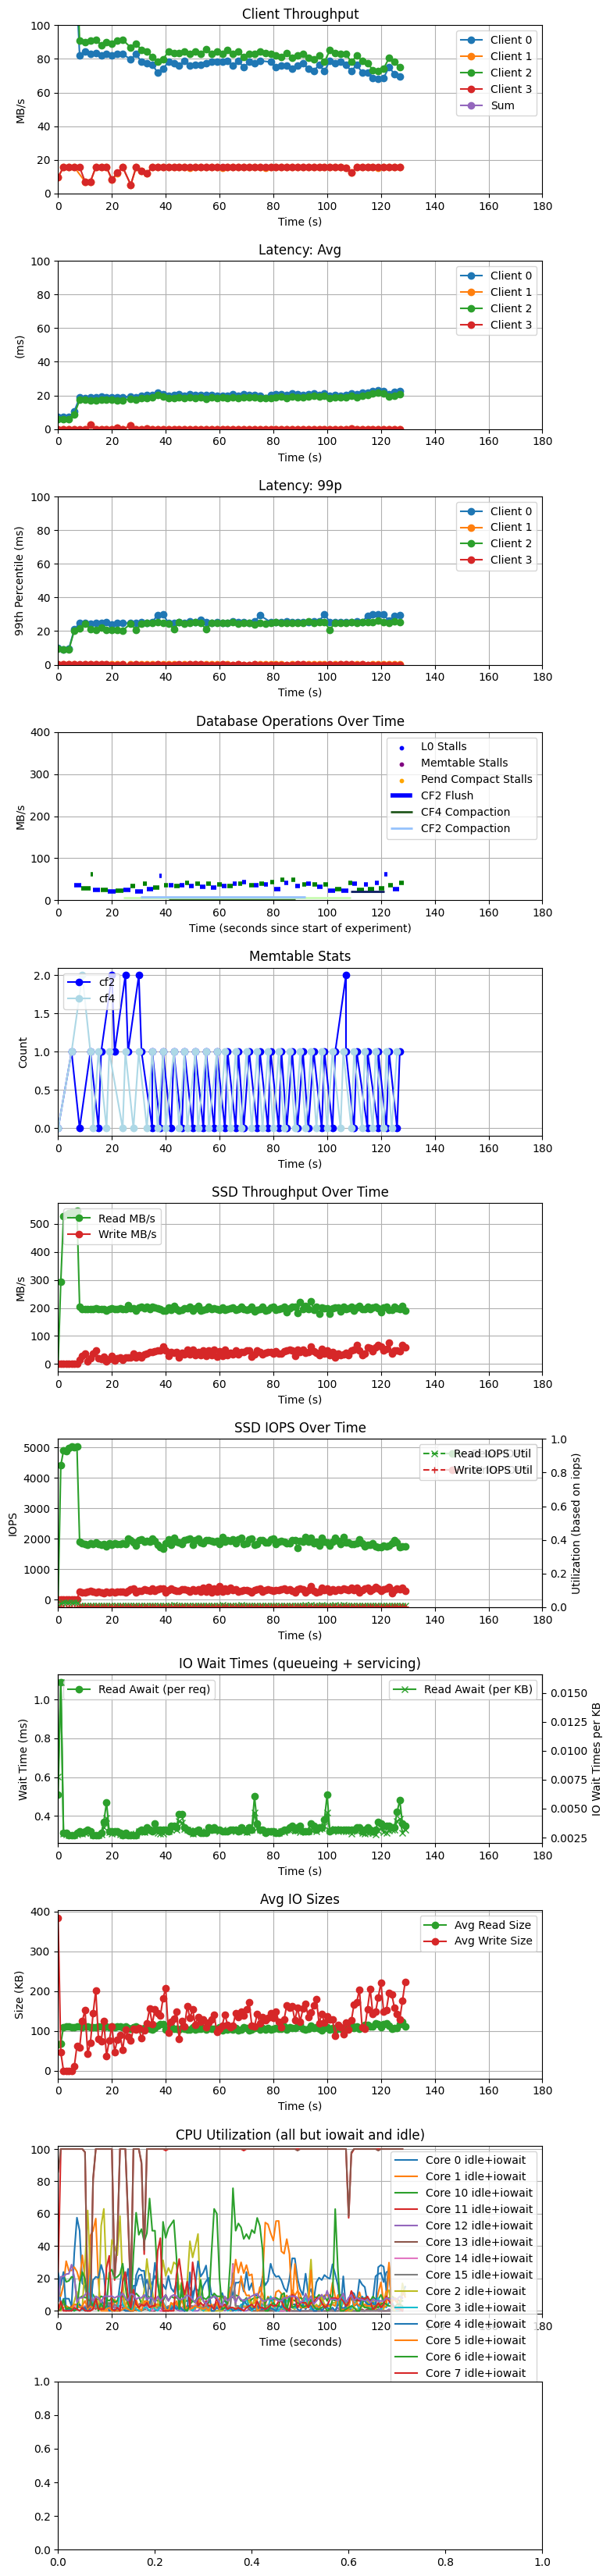

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [59]:
import time 

def generate_plots(xlim, output_file):
  _, axs = plt.subplots(11, 1, figsize=(8, 42))
  plt.subplots_adjust(hspace=0.4)
  start_time = plot_client_results(output_file, axs, xlim)
  plot_rocksdb_events(output_file, axs, start_time, xlim, (3,0))
  plot_memtable_stats(output_file, axs, start_time, xlim, (4,0))

  start_time_shift = 0
  plot_overall_tputs(output_file, axs, start_time_shift, xlim, (5,0))
  plot_overall_iops(output_file, axs, start_time_shift, xlim, (6,0))
  plot_io_waittimes(output_file, axs, start_time_shift, xlim, (7,0))
  plot_io_reqsize(output_file, axs, start_time_shift, xlim, (8,0))
  plot_cpu_util(output_file, axs, start_time_shift, xlim, (9,0))

  # plot_level_stats(output_file, axs, (10, 0))
  plt.show()

xlim = (0, 180)
output_file = "results/timeseries_" + str(int(time.time())) + ".txt"
generate_plots(xlim, output_file)

In [ ]:
import pandas as pd

# Define the path to your blktrace output file
file_path = 'blktrace_output.txt'
columns = ['major_minor', 'cpu', 'sequence', 'timestamp', 'pid', 'action', 'rwbs', 'sector', 'size', 'process']
data = []
temp_storage = {}

with open(file_path, 'r') as file:
  for line in file:
    # Split the line into components based on whitespace
    parts = line.split()

      # Extract the relevant parts of each line (assuming the format is consistent with your example)
    try:
      major_minor = parts[0]
      cpu = int(parts[1])
      sequence = int(parts[2])
      timestamp = float(parts[3])
      pid = int(parts[4])
      action = parts[5]
      rwbs = parts[6]
      sector = int(parts[7])
      size = int(parts[9])
      process = parts[10].strip('[]')
    except:
      continue

    # Use sector and sequence as a unique key
    # unique_key = f"{sector}_{sequence}"
    unique_key = f"{sequence}"

    # For Q action, store the information needed later to calculate duration
    if action == 'Q':
      temp_storage[unique_key] = (cpu, sequence, timestamp, pid, action, rwbs, sector, size, process)
    # For C action, calculate the duration and prepare the row for the DataFrame
    elif action == 'C' and unique_key in temp_storage:
      start_timestamp = temp_storage[unique_key][2]
      duration = timestamp - start_timestamp
      # print(unique_key, duration)
      print(temp_storage[unique_key])
      print(cpu, sequence, timestamp, pid, action, rwbs, sector, size, process)
      print()
      print()
      row = temp_storage[unique_key][:8] + (process, duration)
      data.append(row)
      del temp_storage[unique_key]

    # data.append((major_minor, cpu, sequence, timestamp, pid, action, rwbs, sector, size, process))

df = pd.DataFrame(data, columns=columns)
print(len(df))

FileNotFoundError: [Errno 2] No such file or directory: 'blktrace_output.txt'